In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import xgboost as xgb
from datetime import timedelta
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [12]:
#Safe LabelEncoder để tránh lỗi KeyError
class SafeLabelEncoder(LabelEncoder):
    def transform(self, values):
        return [np.where(self.classes_ == val)[0][0] if val in self.classes_ else -1 for val in values]

In [13]:
# 1. Đọc dữ liệu
train_df = pd.read_csv("../Dataset/712/train.csv", parse_dates=["date"])
valid_df = pd.read_csv("../Dataset/712/validation.csv", parse_dates=["date"])
test_df = pd.read_csv("../Dataset/712/test.csv", parse_dates=["date"])

print("Train:", train_df.shape)
print("Valid:", valid_df.shape)
print("Test:", test_df.shape)

Train: (37620, 15)
Valid: (5374, 15)
Test: (10749, 15)


In [14]:
# 2. Chuẩn bị dữ liệu
features = ['tickets_sold', 'tickets_out', 'show_time', 'occu_perc',
            'ticket_price', 'ticket_use', 'capacity', 'month', 'quarter', 'day', 'year']
target = 'total_sales'

X_train = train_df[features].values
y_train = train_df[target].values

X_valid = valid_df[features].values
y_valid = valid_df[target].values

X_test = test_df[features].values
y_test = test_df[target].values

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

X_valid = scaler_X.transform(X_valid)
y_valid_scaled = scaler_y.transform(y_valid.reshape(-1, 1)).flatten()

X_test = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()


In [15]:
# 3. XGBoost DMatrix
train_dmatrix = xgb.DMatrix(X_train, label=y_train_scaled)
valid_dmatrix = xgb.DMatrix(X_valid, label=y_valid_scaled)
test_dmatrix = xgb.DMatrix(X_test)

In [16]:
# 4. Cấu hình và huấn luyện mô hình
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'learning_rate': 0.1,
    'silent': 1
}

evals = [(train_dmatrix, 'train'), (valid_dmatrix, 'eval')]
model = xgb.train(params, train_dmatrix, num_boost_round=100, evals=evals, early_stopping_rounds=10)

[0]	train-rmse:0.90574	eval-rmse:1.05614
[1]	train-rmse:0.82088	eval-rmse:0.96177
[2]	train-rmse:0.74412	eval-rmse:0.87890
[3]	train-rmse:0.67506	eval-rmse:0.80148
[4]	train-rmse:0.61267	eval-rmse:0.73335
[5]	train-rmse:0.55646	eval-rmse:0.67143
[6]	train-rmse:0.50540	eval-rmse:0.61641
[7]	train-rmse:0.45923	eval-rmse:0.56706
[8]	train-rmse:0.41761	eval-rmse:0.52274
[9]	train-rmse:0.38002	eval-rmse:0.48048
[10]	train-rmse:0.34600	eval-rmse:0.44333
[11]	train-rmse:0.31531	eval-rmse:0.40939
[12]	train-rmse:0.28753	eval-rmse:0.38068
[13]	train-rmse:0.26242	eval-rmse:0.35242


c:\Users\QUYEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:56:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  self.starting_round = model.num_boosted_rounds()


[14]	train-rmse:0.23952	eval-rmse:0.32665
[15]	train-rmse:0.21900	eval-rmse:0.30407
[16]	train-rmse:0.20035	eval-rmse:0.28413
[17]	train-rmse:0.18339	eval-rmse:0.26514
[18]	train-rmse:0.16805	eval-rmse:0.24813
[19]	train-rmse:0.15408	eval-rmse:0.23169
[20]	train-rmse:0.14154	eval-rmse:0.21731
[21]	train-rmse:0.13021	eval-rmse:0.20607
[22]	train-rmse:0.12000	eval-rmse:0.19492
[23]	train-rmse:0.11075	eval-rmse:0.18508
[24]	train-rmse:0.10240	eval-rmse:0.17602
[25]	train-rmse:0.09497	eval-rmse:0.16879
[26]	train-rmse:0.08822	eval-rmse:0.16180
[27]	train-rmse:0.08222	eval-rmse:0.15584
[28]	train-rmse:0.07700	eval-rmse:0.14939
[29]	train-rmse:0.07215	eval-rmse:0.14308
[30]	train-rmse:0.06782	eval-rmse:0.13764
[31]	train-rmse:0.06401	eval-rmse:0.13280
[32]	train-rmse:0.06058	eval-rmse:0.12814
[33]	train-rmse:0.05742	eval-rmse:0.12387
[34]	train-rmse:0.05466	eval-rmse:0.12007
[35]	train-rmse:0.05220	eval-rmse:0.11672
[36]	train-rmse:0.04990	eval-rmse:0.11373
[37]	train-rmse:0.04788	eval-rmse:

In [17]:
# 5. Dự đoán và đánh giá
valid_preds_scaled = model.predict(valid_dmatrix)
valid_preds = scaler_y.inverse_transform(valid_preds_scaled.reshape(-1, 1)).flatten()
y_valid_original = scaler_y.inverse_transform(y_valid_scaled.reshape(-1, 1)).flatten()

val_mae = mean_absolute_error(y_valid_original, valid_preds)
val_rmse = np.sqrt(mean_squared_error(y_valid_original, valid_preds))
val_r2 = r2_score(y_valid_original, valid_preds)
print(f"Validation - MAE: {val_mae:.2f}, RMSE: {val_rmse:.2f}, R²: {val_r2:.2f}")

test_preds_scaled = model.predict(test_dmatrix)
test_preds = scaler_y.inverse_transform(test_preds_scaled.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

test_mae = mean_absolute_error(y_test_original, test_preds)
test_rmse = np.sqrt(mean_squared_error(y_test_original, test_preds))
test_r2 = r2_score(y_test_original, test_preds)
print(f"Test - MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}, R²: {test_r2:.2f}")

Validation - MAE: 430817.36, RMSE: 2109025.58, R²: 1.00
Test - MAE: 291508.97, RMSE: 1789225.41, R²: 1.00


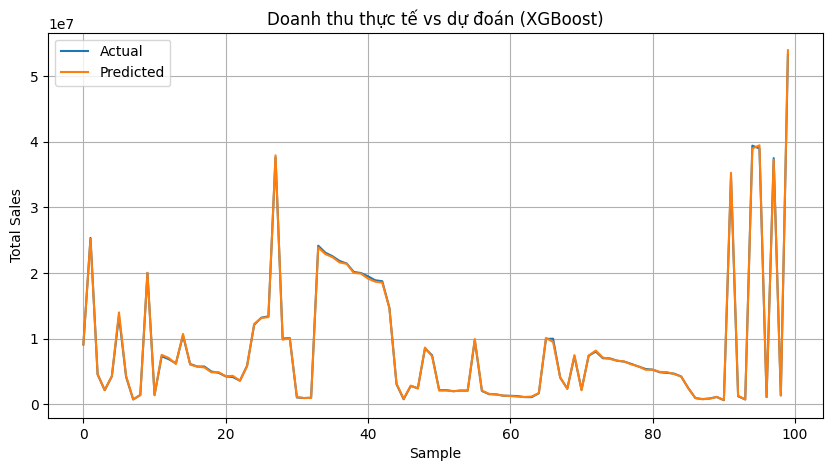

In [18]:
# 6. Vẽ biểu đồ Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test_original[:100], label='Actual')
plt.plot(test_preds[:100], label='Predicted')
plt.legend()
plt.title('Doanh thu thực tế vs dự đoán (XGBoost)')
plt.xlabel('Sample')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()


In [19]:
# 7. Dự đoán tương lai 30 ngày
last_date = test_df['date'].iloc[-1]
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=30).strftime('%Y-%m-%d')

future_X_raw = test_df[features].iloc[-30:].values
future_X_scaled = scaler_X.transform(future_X_raw)
future_dmatrix = xgb.DMatrix(future_X_scaled)
future_preds_scaled = model.predict(future_dmatrix)
future_sales = scaler_y.inverse_transform(future_preds_scaled.reshape(-1, 1)).flatten()

future_df = pd.DataFrame({
    'date': pd.to_datetime(future_dates),
    'total_sales': future_sales,
    'type': 'Forecasted Sales'
})

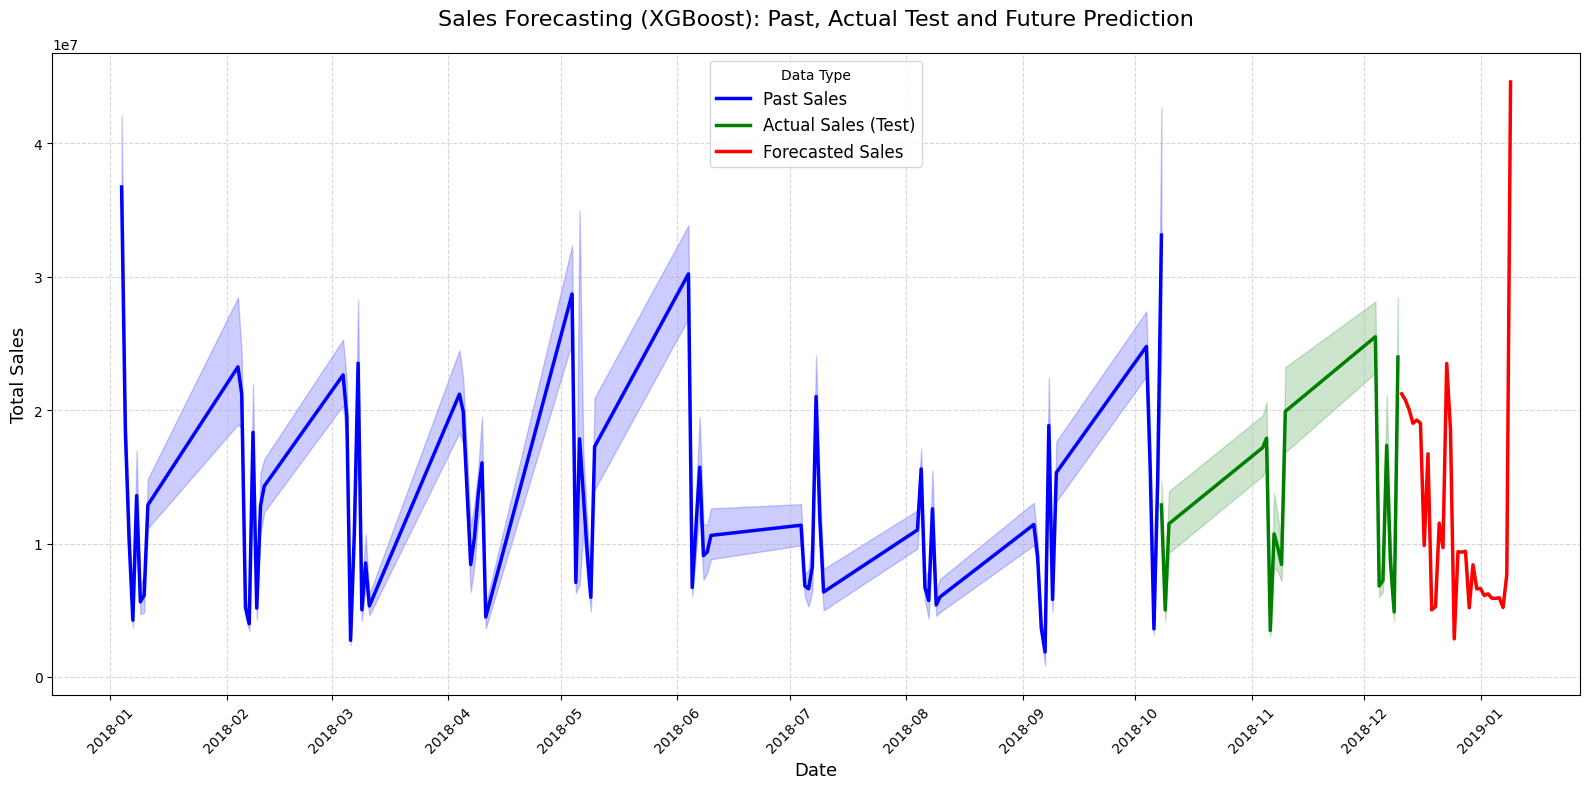

In [20]:
# 8. Visualization tổng thể
train_df['type'] = 'Past Sales'
valid_df['type'] = 'Past Sales'
test_df['type'] = 'Actual Sales (Test)'

combined_df = pd.concat([
    train_df[['date', 'total_sales', 'type']],
    valid_df[['date', 'total_sales', 'type']],
    test_df[['date', 'total_sales', 'type']],
    future_df
], ignore_index=True)

plt.figure(figsize=(16, 8))
sns.lineplot(
    data=combined_df,
    x='date',
    y='total_sales',
    hue='type',
    style='type',
    dashes=False,
    palette={
        'Past Sales': 'blue',
        'Actual Sales (Test)': 'green',
        'Forecasted Sales': 'red'
    },
    linewidth=2.5
)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Total Sales', fontsize=13)
plt.title('Sales Forecasting (XGBoost): Past, Actual Test and Future Prediction', fontsize=16, pad=20)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Data Type', fontsize=12)
plt.tight_layout()
plt.show()